# Pruebas de hipótesis

Uno de los pasos en **ESDA** es el probar si los datos geográficos cuentan con algún tipo de **estructura espacial**. Probar esto es importante ya que si en efecto existe estructura espacial en los datos, entonces se debe incorporar esta misma estructura en todo el análisis.

La parte teórica de este _notebook_ se complementó con diversas secciones del curso [Introduction to Spatial Data Science](https://www.youtube.com/playlist?list=PLzREt6r1NenmFyTw8v2JZpEE4PZGNi5Ht) de la Universidad de Chicago, y se estructura en los siguientes apartados:

* [Aleatoriedad espacial](#Aleatoriedad-espacial)
* [Bases de pruebas de hipótesis](#Bases-de-pruebas-de-hipótesis)
* [Autocorrelación espacial](#Autocorrelación-espacial)
* [Estadísticos para autocorrelación espacial](#Estadísticos-para-autocorrelación-espacial)
    * [Construcción del estadístico](#Construcción-del-estadístico)
    * [Pesos espaciales](#Pesos-espaciales)
    * [Criterios de contigüidad](#Criterios-de-contigüidad)
* [Autocorrelación espacial global](#Autocorrelación-espacial-global)

## Aleatoriedad espacial

Aleatoriedad espacial, también conocidad como _Spatial Randomness_ (**S.R**), es la ausencia de cualquier tipo de patrón espacial en los datos. En términos de análisis es de interés encontrar evidencia en contra de S.R, misma que debe satisfacer dos condiciones:

* Las observaciones son equiprobables de ocurrir en cualquier ubicación en el espacio.
* El valor de una observación no depende del valor de sus vecinos.

La ubicación de las observaciones puede ser alterada sin afectar la información contenida en los datos bajo S.R, esto se puede hacer mediante procesos de permutación de los valores. 

## Bases de pruebas de hipótesis

Dado que es de interés encontrar evidencia en contra de S.R, entonces nos podemos apalancar de la [1° ley geográfica de Tobler](https://en.wikipedia.org/wiki/Tobler%27s_first_law_of_geography) para el planteamiento de pruebas de hipótesis, misma que plantea que en un espacio geográfico "_Todo está relacionado con todo, pero las cosas más cercanas aún más_". Bajo esta ley se pueden extraer dos conclusiones importantes:

1) Hay estructura de dependencia espacial.
2) Existe decaemiento en la correlación de las cosas con la distancia, es decir, observaciones muy separadas estarán menos asociadas.

Lo anterior lleva al planteamiento de **pruebas de hipótesis** apalancadas del concepto de **autocorrelación espacial**, de tal modo que:

* $H_0$: Los datos se distribuyen bajo aleatoriedad espacial.
* $H_1$: Los datos presentan estructura espacial.

## Autocorrelación espacial

La autocorrelación espacial busca medir la variación de una misma variable en ubicaciones distintas, y puede tomar valores tanto **positivos** como **negativos**, lo cual lleva a la interpretación de tres posibles casos:

1) Autocorrelación **positiva**
> Se da cuando las observaciones de una vecindad tienen valores similares, sean negativos (_coldSpot_) o positivos (_hotSpot_), con mayor frecuencia que en S.R, lo cual resulta en la presencia de segmentos geográficos o _clusters_.

2) Autocorrelación **nula**
> No existe autocorrelación en los datos por lo que hay aleatoriedad espacial.

3) Autocorrelación **negativa**
> Se da cuando las observaciones de una vecindad tienen valores opuestos con mayor frecuencia que en S.R, lo cual resulta en estructuras tipo tablero de Ajedrez.

Para ilustrarlo, considera la siguiente figura:

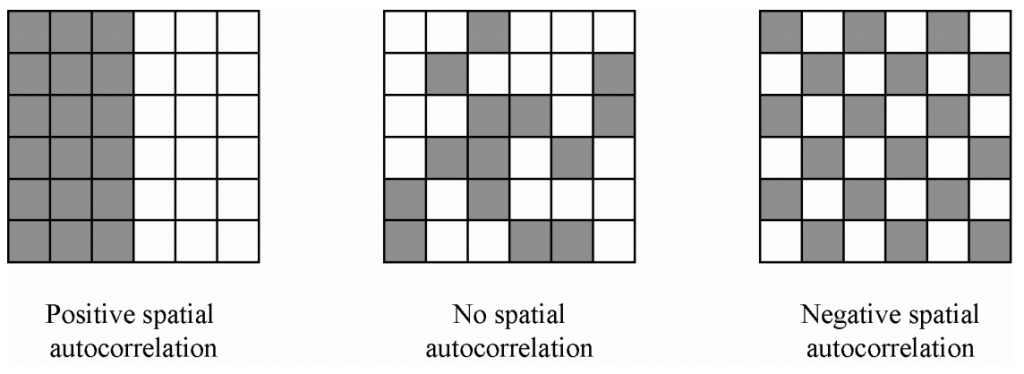

Para el desarrollo de los ejemplos que ilustran estos conceptos, se retomará el caso de los datos de _Airbnb_ para el estado de Nueva York.

Carga de librerías:

In [2]:
# Gestión del sistema
import os
import warnings
os.environ['USE_PYGEOS'] = '0'
#warnings.filterwarnings(action='ignore', module='seaborn\..*')

from IPython.display import display, Markdown

# Librerías de análisis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from numpy.random import seed

# Librerías de análisis espacial
import pysal
import splot
import contextily
import geopandas as gpd
import splot.esda

from pysal.viz import splot
from pysal.lib import weights
from pysal.explore import esda
#from splot.esda import plot_moran, lisa_cluster

Los datos serán los mismos que los que se construyeron en la sección [Mapas sin outliers](../Chapter05/data_visualization.ipynb#Mapas-sin-outliers) del capítulo anterior.

Primero los datos de _airbnb_:

In [3]:
# Rutas relativas a archivos de datos
ROOT = os.path.dirname(os.getcwd())
data_path = os.path.join(ROOT, 'data', 'Data pt1')

# Datos de airbnb
listings = pd.read_csv(
    os.path.join(data_path,'listings.csv.gz')
    ,compression='gzip'
    ,low_memory=False)

# Subconjunto de variables
listings_sub = (
    # Filtro inicial de variables
    listings.filter(
        items=['id','property_type','neighbourhood_cleansed'
               ,'neighbourhood_group_cleansed','accommodates'
               ,'bedrooms','price','latitude','longitude'])
    # Limpieza inicial
    .assign(
        price = lambda _df: _df.price.replace("[$,]", "", regex=True).astype(float)
        ,bedrooms = lambda _df: _df.bedrooms.fillna(value=0)))

# Converción a geoDataFrame
listings_sub_gpd = gpd.GeoDataFrame(
    data=listings_sub
    ,geometry=gpd.points_from_xy(
        x=listings_sub.longitude
        ,y=listings_sub.latitude
        ,crs=4326))

Después los datos del censo de Nueva York:

In [4]:
# Carga de regiones estadísticas de todo Nueva York
NY_tracts_path = "https://www2.census.gov/geo/tiger/TIGER2021/TRACT/tl_2021_36_tract.zip"
NY_Tracts = gpd.read_file(filename=NY_tracts_path)
NY_Tracts = NY_Tracts.to_crs(crs=4326)

Seguido de las _Core-Based Statistical Areas_ (**CBSA**) y agregación de los datos por las mismas:

In [5]:
# Carga de CBSA de todo Estados Unidos
cbsa_path = 'https://www2.census.gov/geo/tiger/TIGER2021/CBSA/tl_2021_us_cbsa.zip'
cbsas = gpd.read_file(filename=cbsa_path)

# Subconjunto de una única CBSA de Nueva York
NY_cbsa = cbsas[cbsas['GEOID']=='35620']

# Intersección espacial para CBSA de Nueva York
mask = NY_Tracts.intersects(other=NY_cbsa.loc[620,'geometry'])
NY_Tracts_subset = NY_Tracts.loc[mask]

# Unir datos de airbnb a conjunto de regiones estadísticas
NY_Tracts_sj = gpd.sjoin(
    left_df=NY_Tracts_subset
    ,right_df=listings_sub_gpd
    ,how='left'
    ,predicate='contains')

# Filtrar variables de interés y agregar media por CBSA
NY_Tracts_sj = NY_Tracts_sj[['GEOID','price','accommodates','bedrooms','geometry']]
NY_Tracts_Agg = NY_Tracts_sj.dissolve(by='GEOID', aggfunc='mean')

Finalmente, la limpieza de _outliers_ de la base

In [6]:
# Media y desv. estándar para eliminar outliers
mean_price = NY_Tracts_Agg['price'].dropna().mean()
stdev = NY_Tracts_Agg['price'].dropna().std()

# Filtrar registros a menos de una std
NY_Tracts_Agg_filtered = NY_Tracts_Agg[NY_Tracts_Agg['price'] < mean_price + stdev]
NY_Tracts_Agg_filtered.reset_index(inplace=True)
NY_Tracts_Agg_filtered.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2085 entries, 0 to 2084
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   GEOID         2085 non-null   object  
 1   geometry      2085 non-null   geometry
 2   price         2085 non-null   float64 
 3   accommodates  2085 non-null   float64 
 4   bedrooms      2085 non-null   float64 
dtypes: float64(3), geometry(1), object(1)
memory usage: 81.6+ KB


## Estadísticos para autocorrelación espacial

Recordando que un **estadístico** es cualquier valor que resume alguna característica de una distribución de referencia ($H_0$), entonces un **estadístico de prueba** es aquel que se calcula de los datos y se compara con esa misma distribución buscando responder a la pregunta:

> ¿Qué tan probable es el estadístico de prueba si éste hubiera ocurrido bajo la $H_0$?

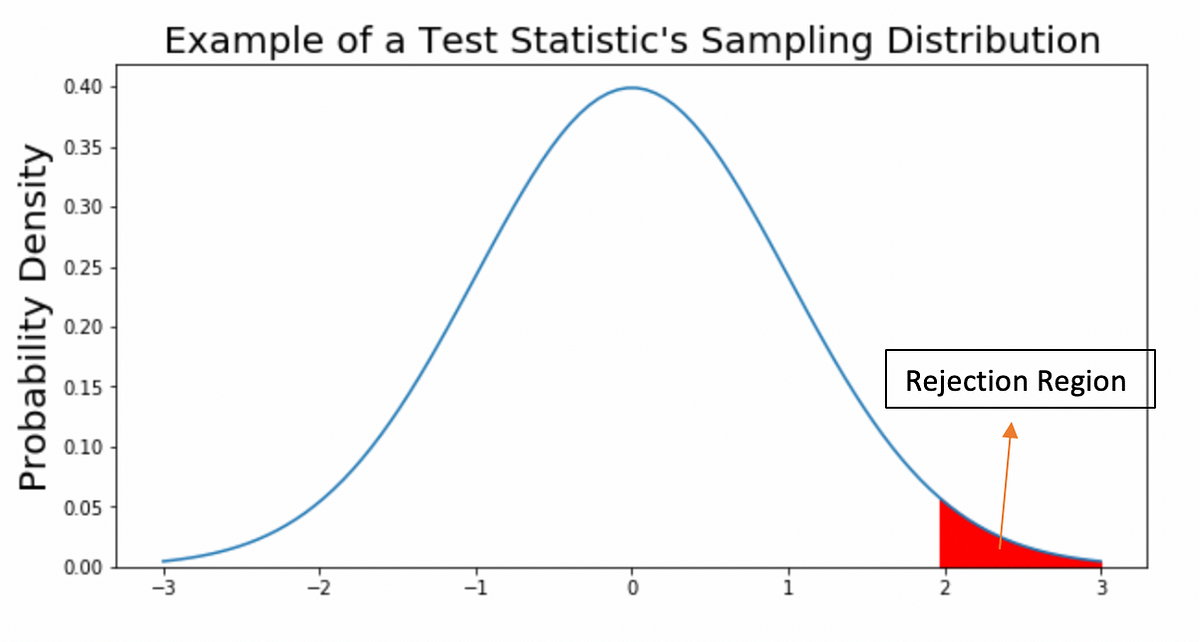

Éste entonces acepta o rechaza la $H_0$ en función de si la probabilidad de observar esos datos supera o no la región de rechazo en la distribución de referencia.

### Construcción del estadístico

Para construir un estadístico de prueba en un contexto espacial es necesario que éste capture tanto la **similitud de atributos** como la **similitud de ubicación**, y además debe ser construido a partir de los mismos datos.

* Similitud de **atributos**: $f(y_i, y_j)$
> Resume la similitud de diferentes observaciones de una misma variable $y$ en las diferentes ubicaciones $i$, $j$, de modo que es una función $f(y_i,y_j)$.

* Similitud de **ubicación**: $w_{ij}$
> Formaliza la noción de un vecino a través de los **pesos espaciales** $w_{ij}$ que se almacenan en la matriz de pesos espaciales $W$ a través de algún tipo de interacción.

Con estas dos dos partes se puede construir un estadístico $z$ que sume a lo largo de todos los pares de observaciones $(i, j)$ el producto de la similitud de atributos con la similitud de ubicación, de modo que:

$$z = \sum_{ij}f(y_i,y_j)\cdot w_{ij}$$

### Pesos espaciales

Es **sumamente importante** entender el siguiente concepto:

> La autocorrelación espacial se basa fundamentalmente en definir la **interacción entre un par de observaciones** para todos los posibles pares de observaciones de un espacio geográfico. En ese sentido, el principal problema es que para $n$ observaciones se tendría que determinar la interacción de aproximadamente $n\cdot(\frac{n-1}{2})$ interacciones por pares.
>
> Lo anterior es algo que no será posible erradicar debido a un **problema incidental de pramátros**, es decir, el número de parámetros aumenta a medida que aumenta el número de observaciones. Para interacciones espaciales, el número de parámetros crece en $n^2$.

La solución radica entonces en imponer algún tipo de estructura a los datos para limitar el número de parámetros por estimar, es aquí en donde los [**pesos espaciales**](https://www.youtube.com/watch?v=yjFNuyfskaQ) desempeñan un papel esencial al formalizar la noción de vecinos. Fundamentalmente, los pesos espaciales están diseñados para **excluir algunas interacciones** al limitar el número de vecinos de una observación, por ejemplo, considerando aquellas ubicaciones con las que comparte una frontera.

Entonces la **escala de interacción** entre pares de observaciones queda definida por un efecto combinado entre el **coeficiente de correlación** asociado a la similitud de atributos, y el **peso** asociado a la similitud de ubicación.

Con la definición de los pesos espaciales, el siguiente paso sería construir la **Matriz de Pesos Espaciales** ($W$) en función de algún tipo de criterio, que es una matríz de $nxn$ que almacena a cada peso $w_{ij}$ y que cumple con las siguientes características:

* $w_{ij}\neq 0$ para vecinos.
* $w_{ij} = 0$ implica que $i$ y $j$ no son vecinos.
* $w_{ii} = 0$ dado que no hay similitud entre una observación con ella misma.

Esto provoca que $W$ sea una matriz con un gran número de elementos en $0$, mismos que anulan el efecto de la interacción entre observaciones y que por tanto reducen el número de parámetros por calcular.

### Criterios de contigüidad

Como se mencionó, la matriz de pesos se debe definir bajo algún criterio determinado, mismos que son conocidos como **criterios de contigüidad**. Escencialmente existen dos clasificaciones para estos criterios:

#### Criterios binarios:

Se trata del tipo de criterio más simple, se asignan **pesos booleanos** a las observaciones que comparten algún tipo de frontera física.

* $w_{ij}=0$: No se comparte frontera física
* $w_{ij}=1$: Se comparte alguna frontera

El siguiente ejemplo ilustra la idea detrás de un criterio binario de contigüidad:

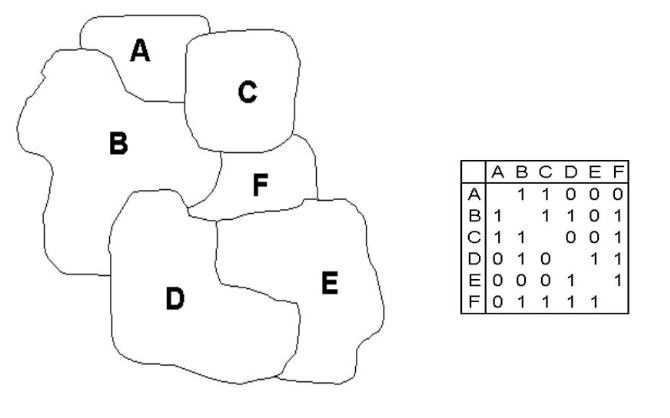

Sin embargo, al construir la matriz de pesos utilizando criterios binarios se tienen complicaciones que resultan en dos enfoques a la hora de definir el qué es una frontera:

* Matriz de **Contigüidad de Torre**:
> Para la definición de contigüidad considera **únicamente fronteras completas**. Su nombre es alusivo al movimiento de una torre en ajedrez.

* Matriz de **Contigüidad de Reina**:
> Para la definición de contigüidad considera tanto **fronteras completas** como **esquinas**. Su nombre es alusivo al movimiento de una reina en ajedrez.

Para ilustrarlo mejor, considera la siguiente figura:

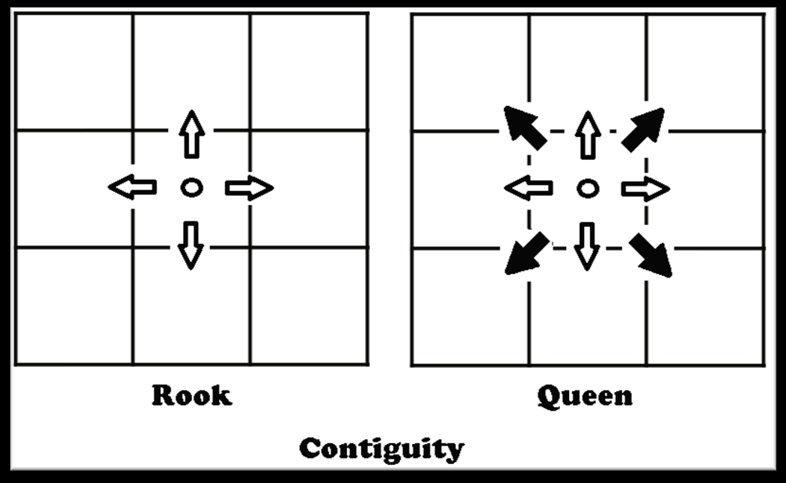

#### Criterios basados en distancia

In [6]:
# Matriz de pesos
w = weights.Queen.from_dataframe(
    df=NY_Tracts_Agg_filtered
    ,silence_warnings=True)
w.transform = 'R'

# Vista preliminar
w.sparse

<2085x2085 sparse matrix of type '<class 'numpy.float64'>'
	with 12266 stored elements in Compressed Sparse Row format>

In [7]:
display(Markdown(data=f'''
Número de entradas: **{w.n:,}**
<br>Número de vecinos:
* Min: **{w.min_neighbors}**
* Media: **{w.mean_neighbors:.2f}**
* Max: **{w.max_neighbors}**'''))


Número de entradas: **2,085**
<br>Número de vecinos:
* Min: **1**
* Media: **5.88**
* Max: **28**

## Autocorrelación espacial global

**IMPORTANTE**: Para los siguientes bloques de código se utilizarán funciones de `PySAL`, para lo cual se debe estar familiarizado con la [documentación](https://pysal.org/libpysal/api.html#spatial-weights)

Existen algunos estadísticos comunes para probar la autocorrelación espacial global. El primero de ellos, y el más común, es el estadístico _**Moran's I**_.

### Moran's I

Una prueba de hipótesis que se puede realizar es la [_Moran's I_](https://en.wikipedia.org/wiki/Moran%27s_I), que mide la autocorrelación espacial basada en en el valor y la ubicación de las observaciones. Para entender su funcionamiento son necesarios dos conceptos.

El estadístico _Moran's I_ se determina mediante la siguiente expresión:

$$Moran^I = \frac{N}{S_0}\frac{\sum_{i=1}^N\sum_{j=1}^N w_{i,j}(x_i-\bar x)(x_j-\bar x)}{\sum_{i=1}^N (x_i-\bar x)^2}$$

En donde:

* $N$: Número de entradas
* $S_0$: Agregado de todos los pesos espaciales
* $w_{i,j}$: Peso espacial de la entrada $i,j$
* $(x_i-\bar x)$: Valor estandarizado de la variable de interés
* $(x_j-\bar x)$: Valor estandarizado del rezago de la variable de interés
* $\bar x$: Media de la variable de interés

Para ilustrarlo, se continúo con el ejmplo de los datos de _Airbnb_ con la siguiente secuencia de transformaciones:


**Paso 2**: Calcular rezago de las observaciones y centrar con la media

In [8]:
# Calcular columnas de rezago
NY_Tracts_Agg_filtered = (
    NY_Tracts_Agg_filtered
    .assign(
        # Rezago en el precio
        price_lag = lambda _df: weights.spatial_lag.lag_spatial(w=w, y=_df.price)
        # Centrar precio a la media
        ,price_std = lambda _df: _df.price - _df.price.mean()
        # Centrar rezago de precio a la media
        ,price_lag_std = lambda _df: _df.price_lag - _df.price_lag.mean())
)

**Paso 3**: Graficar variable de interés contra el rezago de la misma para producir la **dispersión Moran's I**

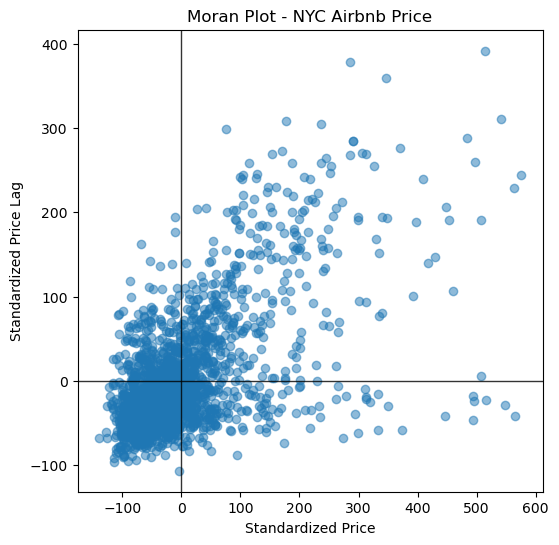

In [9]:
# Especificaciones de figura
fig, ax = plt.subplots(1, figsize=(6,6))

# Elementos de visualización
ax.scatter(
    x=NY_Tracts_Agg_filtered.price_std
    ,y=NY_Tracts_Agg_filtered.price_lag_std
    ,color='tab:blue'
    ,alpha=0.5)
ax.axvline(0, color='black', linewidth=1, alpha=0.8)
ax.axhline(0, color='black', linewidth=1, alpha=0.8)

# Anotaciones y estilo
ax.set(
    title='Moran Plot - NYC Airbnb Price'
    ,xlabel='Standardized Price'
    ,ylabel='Standardized Price Lag')

plt.show()

Cosas que se deben destacar de la visualización anterior:

* Los puntos que están en el cuadrante superior derecho tienen autocorrelación espacial global **positiva**
* Los puntos en el cuadrante inferior izquierdo tienen autocorrelación espacial global **negativa**

También es posible extraer información adicional del estadístico de Moran:

In [10]:
# Estadístico de Moran I
morans_stat = esda.moran.Moran(
    y=NY_Tracts_Agg_filtered.price_std
    ,w=w)

# Vista preliminar
display(Markdown(f'''
**Morans I:** {morans_stat.I:.3f}
<br>**p-value:** {morans_stat.p_sim:.3f}
'''))


**Morans I:** 0.420
<br>**p-value:** 0.001


Una forma rápida de inspeccionar el estadístico de Moran es utilizando la función `splot.esda.plot_moran()`, que regresa el siguiente panel:

C:\Users\Miguel\miniconda3\envs\GeospatialPython\lib\site-packages\splot\_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


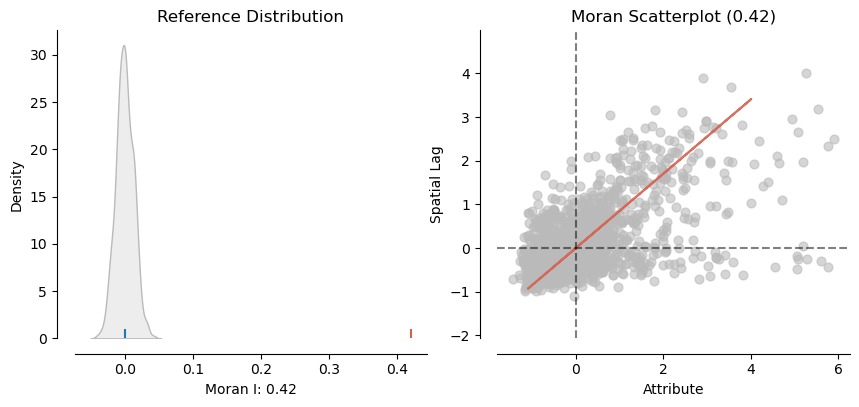

In [20]:
splot.esda.plot_moran(
    moran=morans_stat
    ,fill=True)

plt.show()

**Morans I for accommodates:** 0.11319932036298101

**p-value for accommodates:** 0.001

**Morans I for bedrooms:** 0.10262754083216395

**p-value for bedrooms:** 0.001

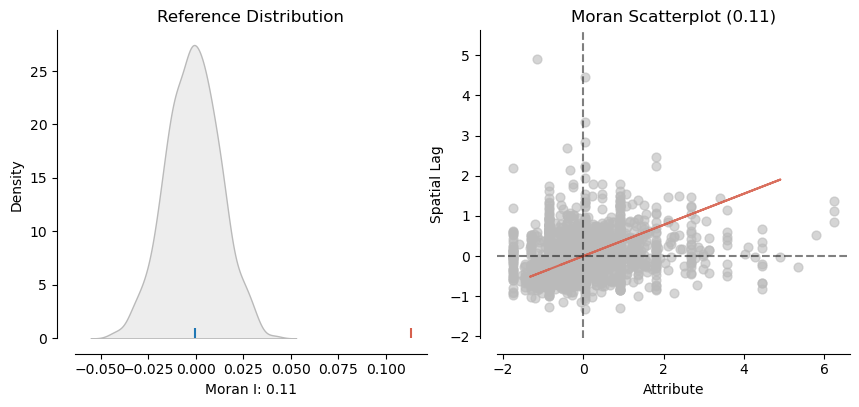

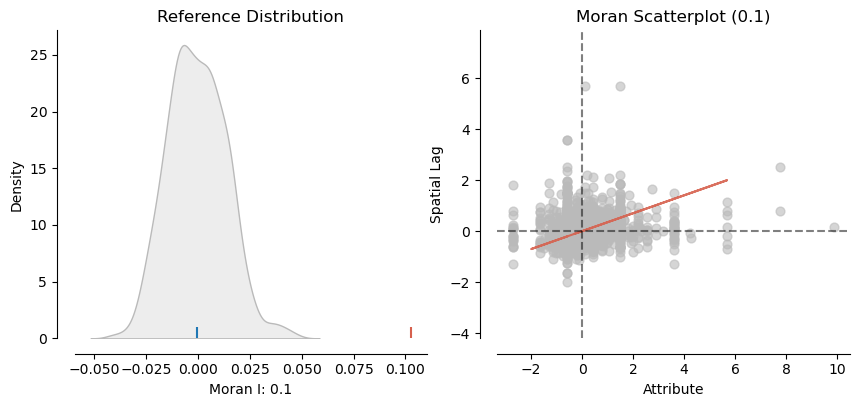

In [10]:


# Set seed for reproducibility
np.random.seed(54321)

# Set the variables of interest
variables_of_interest = ['accommodates','bedrooms']

for voi in variables_of_interest:
    morans_stat = esda.moran.Moran(NY_Tracts_Agg_filtered[voi], w)
    display(Markdown(f"""**Morans I for {voi}:** {morans_stat.I}"""))
    display(Markdown(f"""**p-value for {voi}:** {morans_stat.p_sim}"""))
    plot_moran(morans_stat)


#### 2.1.2 Geary's C

In [11]:
# Set the variables of interest
variables_of_interest = ['price','accommodates','bedrooms']

for voi in variables_of_interest:
    geary_c = esda.geary.Geary(NY_Tracts_Agg_filtered[voi], w)
    display(Markdown(f"""**Geary's C for {voi}:** {geary_c.C}"""))
    display(Markdown(f"""**p-value for {voi}:** {geary_c.p_sim}"""))

**Geary's C for price:** 0.5752241719341424

**p-value for price:** 0.001

**Geary's C for accommodates:** 0.8726235585071773

**p-value for accommodates:** 0.001

**Geary's C for bedrooms:** 0.8857747630853288

**p-value for bedrooms:** 0.001

### 2.2 Local Spatial Autocorrelation

In [12]:
price_lisa = esda.moran.Moran_Local(NY_Tracts_Agg_filtered['price'], w)

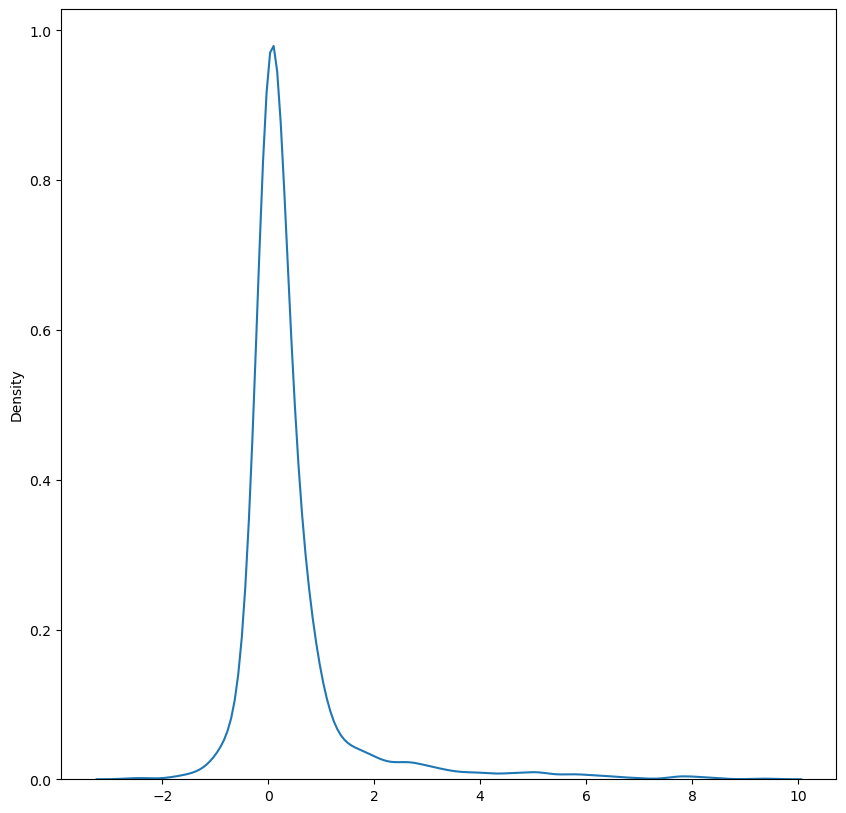

In [13]:
# Draw KDE line
f, ax = plt.subplots(1, figsize=(10, 10))
seaborn.kdeplot(price_lisa.Is, ax=ax)

plt.show()

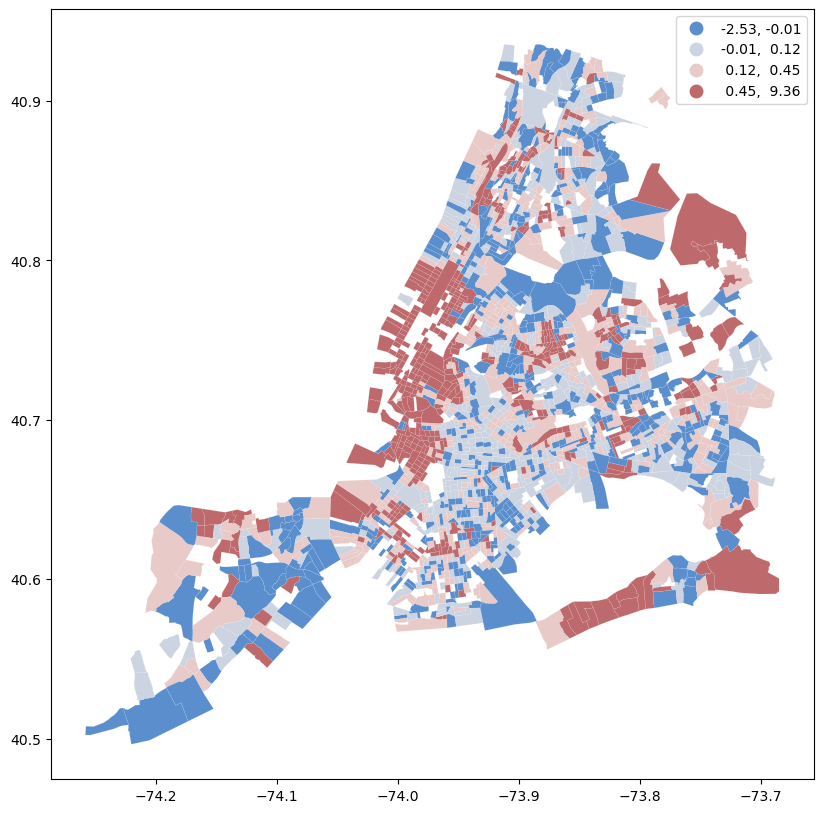

In [14]:
f, ax = plt.subplots(1, figsize=(10, 10))

# Create a new column with the values from the Moran's Local LISAs
NY_Tracts_Agg_filtered.assign(
    ML_Is=price_lisa.Is
    
# Plot choropleth of local statistics
).plot(
    column='ML_Is', 
    cmap='vlag', 
    scheme='quantiles',
    k=4, 
    edgecolor='white', 
    linewidth=0.1, 
    alpha=0.75,
    legend=True,
    ax=ax
)

plt.show()

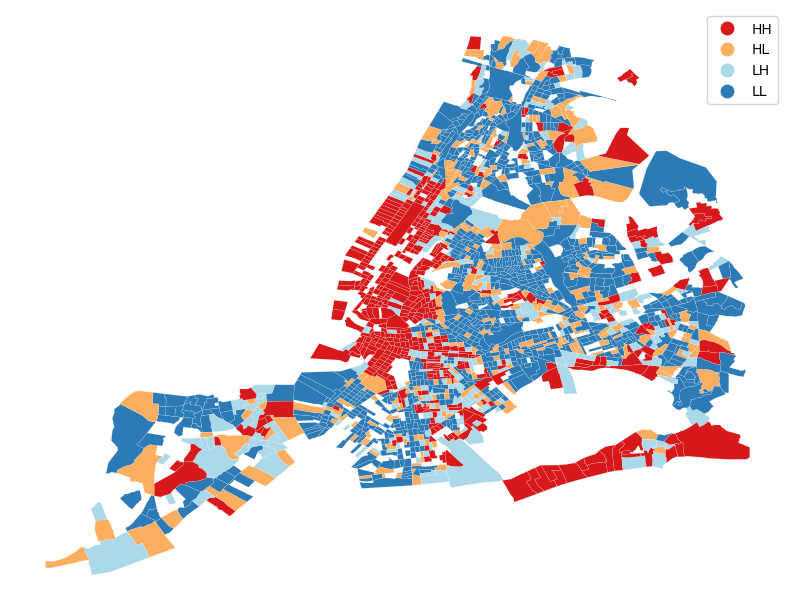

In [15]:
# Plot a map assigning each observation with its quadrant value HH, HL, LH, LL
f, ax = plt.subplots(1, figsize=(10, 10))
lisa_cluster(price_lisa, NY_Tracts_Agg_filtered, p=1, ax=ax);

plt.show()

<AxesSubplot:>

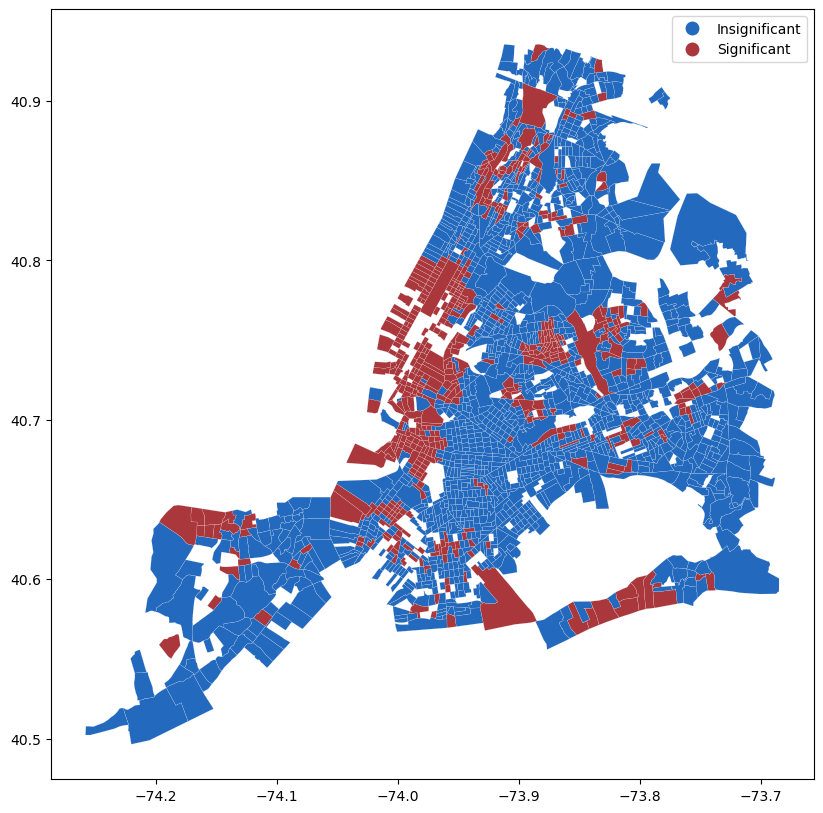

In [16]:
f, ax = plt.subplots(1, figsize=(10, 10))

# First, we need to find out which observations are significant
alpha = 0.05
labels = pd.Series(
    1 * (price_lisa.p_sim < alpha), # 1: Indicates significance at alpha of .05 and 0 indicates insignificant values
    index=NY_Tracts_Agg_filtered.index

# Recoding 1 to be "Significant and 0 to be "Insignificant"
).map({1: 'Significant', 0: 'Insignificant'})

# Creating a new column with the labels for significance called ML_Sig
NY_Tracts_Agg_filtered.assign(
    ML_Sig=labels

# Ploting a map of the insignificant values
).plot(
    column='ML_Sig', 
    categorical=True,
    k=2,
    cmap='vlag',
    linewidth=0.1,
    edgecolor='white',
    legend=True,
    ax=ax
)

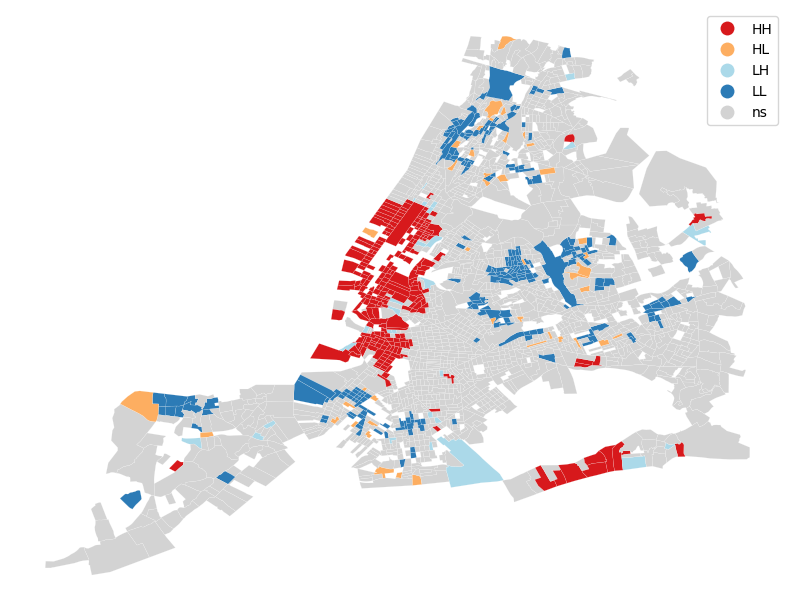

In [17]:
# Plot one final map using the alpha of 0.05
f, ax = plt.subplots(1, figsize=(10, 10))

lisa_cluster(price_lisa, NY_Tracts_Agg_filtered, p=alpha, ax=ax);

plt.show()